In [129]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acovf, acf, pacf
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [130]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

Testy

In [131]:
def adf_test(x, alpha=0.05):
    p_val = []
    is_stationary = []
    trend = ['Stała', 'Linia', 'Parabola', 'Brak']
    trends = ['c', 'ct', 'ctt', 'n']

    for i in trends:
        result = adfuller(x, regression=i, autolag='AIC')
        p = result[1]
        p_val.append(p)
        if p < alpha:
            is_stationary.append('Tak')
        else:
            is_stationary.append('Nie')

    return pd.DataFrame({
        'Trend': trend,
        'P-value': p_val,
        f'Stacjonarny (α={alpha})': is_stationary
        })

def normality_tests(data):
    # Parametry dla rozkładu normalnego
    loc, sc = st.norm.fit(data)

    # Test Kolmogorova-Smirnova
    ks_result = st.kstest(data, 'norm', args=(loc, sc))
    ks_stat, ks_p_value = ks_result.statistic, ks_result.pvalue
    
    # Test normalności (D'Agostino i Pearson)
    normaltest_stat, normaltest_p_value = st.normaltest(data)

    # Test Shapiro-Wilka
    shapiro_stat, shapiro_p_value = st.shapiro(data)
    print(shapiro_stat,shapiro_p_value)
    
    # Interpretacja wyników
    print("Test Kolmogorova-Smirnova:")
    print(f"Statystyka: {ks_stat:.4f}, p-wartość: {ks_p_value:.4f}")
    print("Wynik testu Kolmogorova-Smirnova:")
    if ks_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu normalnego.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu normalnego.")
    
    print("\nTest D'Agostino i Pearson:")
    print(f"Statystyka: {normaltest_stat:.4f}, p-wartość: {normaltest_p_value:.4f}")
    print("Wynik testu D'Agostino i Pearson:")
    if normaltest_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą być normalnie rozłożone.")
    
    print("\nTest Shapiro-Wilka:")
    print(f"Statystyka: {shapiro_stat:.4f}, p-wartość: {shapiro_p_value:.4f}")
    print("Wynik testu Shapiro-Wilka:")
    if shapiro_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą być normalnie rozłożone.")

def t_student_tests(data):
    # Parametry dla rozkładu t-Studenta
    d_f, loc, sc = st.t.fit(data)
    print(d_f, loc, sc)
    # Test t-Studenta dla średniej
    t_stat, t_p_value = st.ttest_1samp(data, popmean=loc)
    
    # Test Kolmogorova-Smirnova z rozkładem t-Studenta
    ks_stat, ks_p_value = st.kstest(data, st.t(d_f, loc, sc).cdf)
    
    # Interpretacja wyników
    print("Test t-Studenta:")
    print(f"Statystyka t: {t_stat:.4f}, p-wartość: {t_p_value:.4f}")
    print("Wynik testu t-Studenta:")
    if t_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: średnia próby różni się od zadanej wartości.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.")
    
    print("\nTest Kolmogorova-Smirnova:")
    print(f"Statystyka: {ks_stat:.4f}, p-wartość: {ks_p_value:.4f}")
    print("Wynik testu Kolmogorova-Smirnova:")
    if ks_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu t-Studenta.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.")


def parametry(X):
    '''funkcja zwraca tabele z wynikami'''
    # główne parametry
    mean = np.mean(X)
    n = len(X)
    
    # odchylenie standardow
    std = np.std(X)
    # odchylenie przeciętne
    przec_std = np.sum(np.abs(X - mean)) / (n-1)
    
    # rozstęp międzykwartylowy
    q = np.quantile(X, [0.25, 0.75])
    rozstep = q[1]-q[0]

    # odchylenie ćwiartkowe
    cwiartk = (q[1] - q[0]) / 2
    
    # semiodchylenie standardowe
    semi_std = np.sqrt(np.sum(X[X -mean>0] ** 2) / (n-1) )
    # semidochylenie przeciętne
    semi_przec = np.sum(np.abs(X[X -mean>0] - mean)) / (n-1)

    # współczynnik zmienności
    zmiennosc = std/mean

    nazwy = ['Odchylenie standardowe', 'Odchylenie przeciętne', 'Rozstęp międzykwartylowy', 'Odchylenie ćwiartkowe', 
             'Semiodchylenie standardowe', 'Semiodchylenie przeciętne', 'Średnia', 'Współczynnik zmienności']
    wartosci = [std, przec_std, rozstep, cwiartk, semi_std, semi_przec, mean, zmiennosc]
    data = pd.DataFrame({'Miara':nazwy, 'Wartość':wartosci})
    return data

def kwantyle(df, title, levels_df=[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]):
    # wykres
    levels = np.arange(0.01, 1, 0.01)
    q = np.quantile(df, levels)
    sns.lineplot(x=levels, y=q, color = 'black')
    plt.title(f'Wykres kwantylowy dla {title}')
    plt.show()
    
    # tabela z wynikami
    q = np.quantile(df, levels_df)
    data = pd.DataFrame({'Kwantyl':levels_df, 'Wartość':q})
    return data

def wartosc_dystrybuanty(X, wartosci=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5]):
    ecdf = ECDF(X)
    data = pd.DataFrame({'Ustalona wartość':wartosci, 'wartość dystrybuanty':ecdf(wartosci)})
    return data

# Pobranie i przekształcenie danych

[*********************100%***********************]  1 of 1 completed


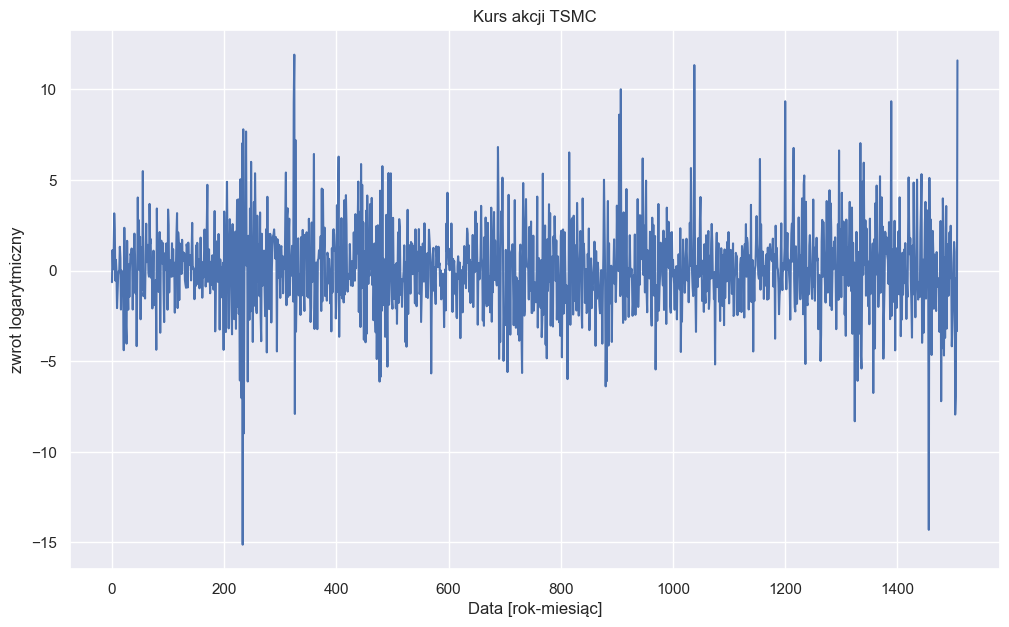

In [132]:
tsmc_data = yf.download('TSM', period = '6y')
tsmc_data = tsmc_data['Close']

log_ret_tsmc = np.log(tsmc_data / tsmc_data.shift(1)).dropna()*100
log_ret_tsmc = np.ravel(log_ret_tsmc)

plt.plot(log_ret_tsmc)
plt.title('Kurs akcji TSMC')
plt.ylabel('zwrot logarytmiczny')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed


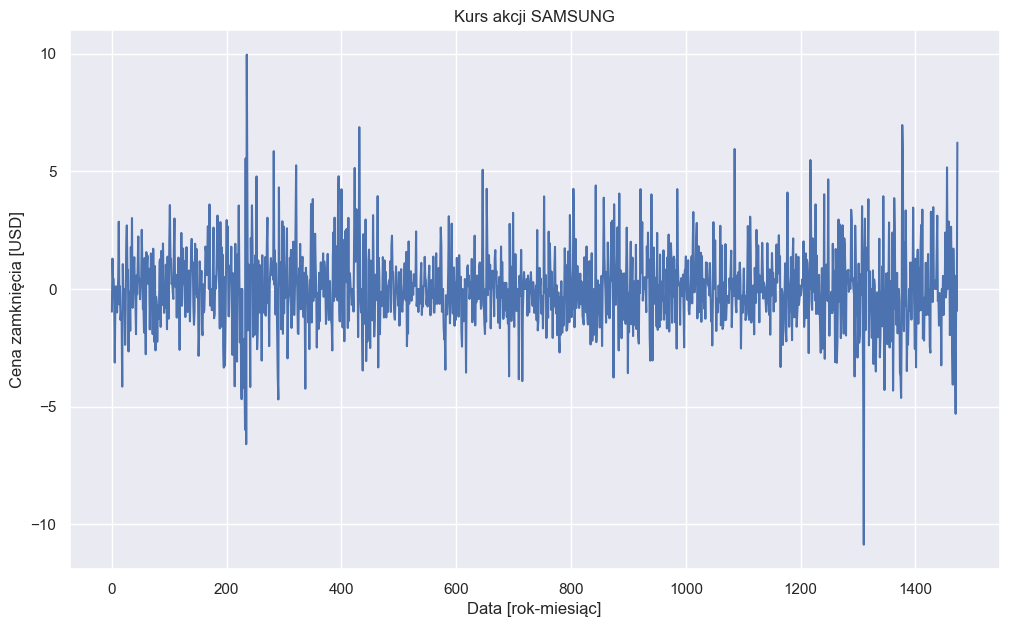

In [133]:
smg_data = yf.download('005930.KS', period = '6y')
smg_data = smg_data['Close']

log_ret_smg = np.log(smg_data / smg_data.shift(1)).dropna() *100
log_ret_smg = np.ravel(log_ret_smg)

plt.plot(log_ret_smg)
plt.title('Kurs akcji SAMSUNG')
plt.ylabel('Cena zamknięcia [USD]')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()

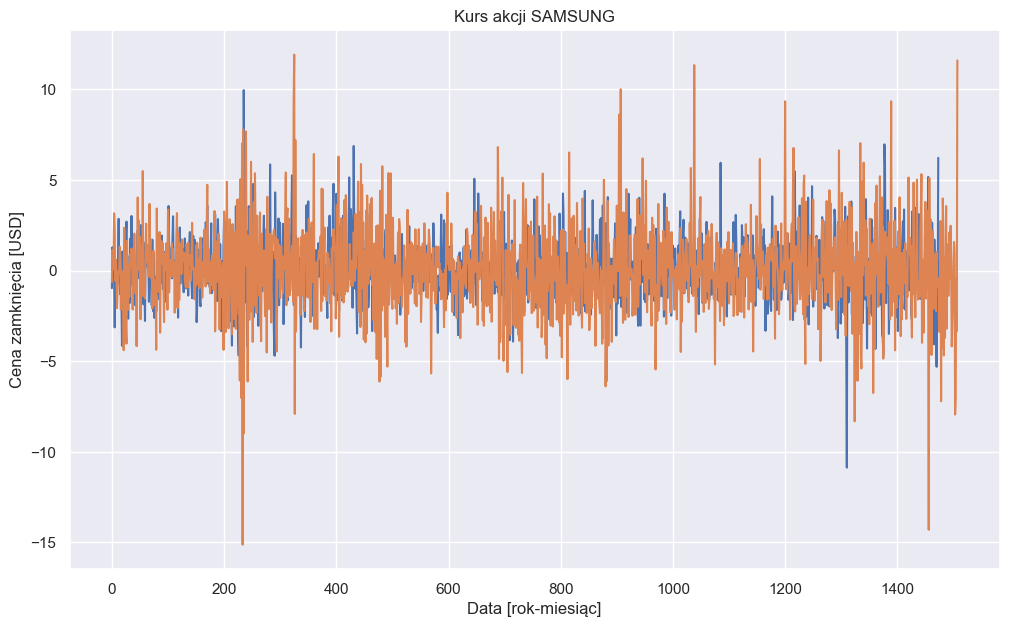

In [134]:
#obydwa na jednym
plt.plot(log_ret_smg)
plt.plot(log_ret_tsmc)
plt.title('Kurs akcji SAMSUNG')
plt.ylabel('Cena zamknięcia [USD]')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()

## Dane z TSMC są większe, dlatego trzeba zbiór danych przyciąć

In [135]:
print(len(log_ret_tsmc), len(log_ret_smg))
log_ret_tsmc = log_ret_tsmc[:len(log_ret_smg)]
print(len(log_ret_tsmc), len(log_ret_smg))

1508 1474
1474 1474


Przeanalizowaliśmy już te dane z osobna i wiemy, że mogą one pochodzić z rozkładu t-Studenta z 5-cioma stopniami swobody. Możemy tego użyć do utworzenia rozkładu dwuwymiarowego

In [136]:
data_comb = np.column_stack((log_ret_tsmc, log_ret_smg))
data_comb

array([[-0.63927135, -0.96828027],
       [ 1.13369885,  1.28897449],
       [ 0.07042152,  0.42596655],
       ...,
       [-0.57052539,  0.56232576],
       [-0.88683134, -0.93897403],
       [-0.42388487,  6.2177245 ]])

Teraz policzymy wektor średnich i wariancji

In [137]:

print("Wektor średnich [TSMC, Samsung]: \n ",np.mean(data_comb,axis = 0),"\n")

print("Macierz kowariancji \n",np.cov(data_comb.T),"\n")

print("Macierz korelacji \n", np.corrcoef(data_comb.T))

Wektor średnich [TSMC, Samsung]: 
  [0.11500959 0.023042  ] 

Macierz kowariancji 
 [[ 5.54360085 -0.09955017]
 [-0.09955017  2.79104404]] 

Macierz korelacji 
 [[ 1.         -0.02530828]
 [-0.02530828  1.        ]]


### Ważna uwaga, TSMC ma większą średnią, ale też większą wariancję (ryzyko), Samsung ma mniejszą średnią, zaś też mniejsze ryzyko

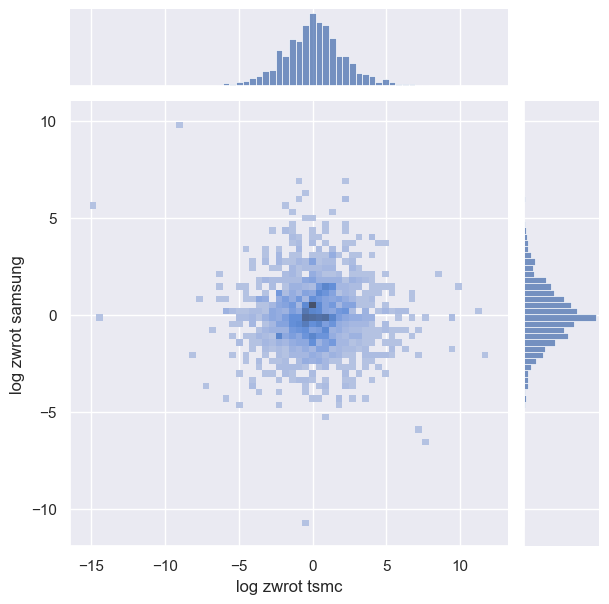

In [138]:
g = sns.JointGrid(x=log_ret_tsmc, y=log_ret_smg)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.histplot)
g.set_axis_labels('log zwrot tsmc', 'log zwrot samsung')

# Definicja Portfel

In [139]:
class Portfel:
    """_summary_
    """
    def __init__(self, data_comb, odset_tsmc:float=.5) -> None:
        self.odset_tsmc = odset_tsmc
        self.odset_smg = 1 - odset_tsmc
        self.log_tsmc = data_comb[:,0]
        self.log_smg = data_comb[:,1]
    
    @property
    def mean(self):
        return self.odset_tsmc*self.log_tsmc.mean() + self.odset_smg*self.log_smg.mean()
    
    @property
    def var(self):
        return self.odset_tsmc*self.odset_tsmc*self.log_tsmc.var() + self.odset_smg*self.odset_smg*self.log_smg.var() + \
            2*self.odset_smg*self.odset_tsmc*self.log_smg.std()* self.log_tsmc.std()*np.corrcoef(self.log_smg[1:],self.log_tsmc[1:])[1,0]

    def quantile(self, q):
        return np.quantile(self.log_tsmc[1:], q)*self.odset_tsmc + np.quantile(self.log_smg[1:], q)*self.odset_smg

    def __getitem__(self, key):
        return self.log_tsmc[1:][key]*self.odset_tsmc + \
            self.log_smg[1:][key]*self.odset_smg

Wygenerowanie wszystkich możliwości portfela

In [140]:
space = np.linspace(0, 1, 100)
means = []
vars = []
for i in space:
    p = Portfel(data_comb, odset_tsmc=i)
    means.append(p.mean)
    vars.append(p.var)
space[vars == min(vars)]

array([0.34343434])

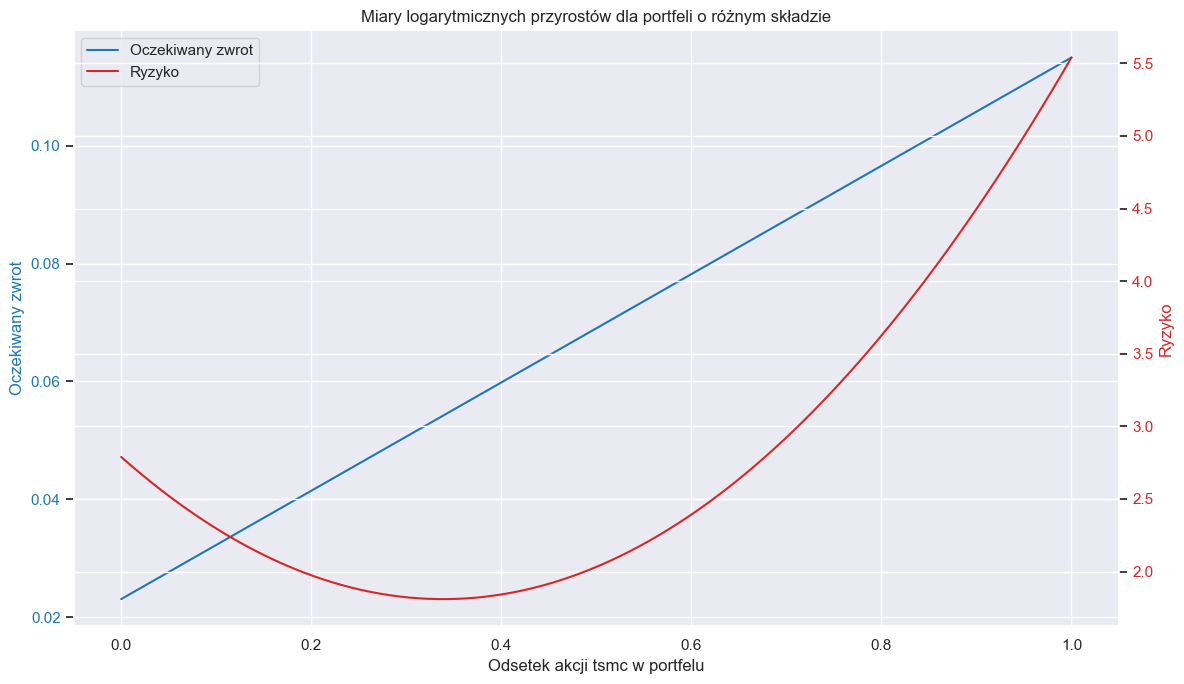

In [141]:
fig, ax1 = plt.subplots()

# Pierwszy wykres — oczekiwany zwrot (lewa oś Y)
ax1.plot(space, means, color='tab:blue', label='Oczekiwany zwrot')
ax1.set_ylabel('Oczekiwany zwrot', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Miary logarytmicznych przyrostów dla portfeli o różnym składzie')
ax1.set_xlabel('Odsetek akcji tsmc w portfelu')

# Drugi wykres — ryzyko (prawa oś Y)
ax2 = ax1.twinx()
ax2.plot(space, vars, color='tab:red', label='Ryzyko')
ax2.set_ylabel('Ryzyko', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# (Opcjonalnie) Dodanie wspólnej legendy
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

Bazując na wykresie, najlepiej będzie wybrać odsetek akcji tsmc równy 0.5, gdyż wtedy ryzyko zaczyna szybciej wzrastać. Tworzymy zatem portfel

In [142]:
portfel = Portfel(data_comb,0.5)
p = 0.5*log_ret_smg + 0.5*log_ret_tsmc

# Analiza portfela
## Podejscie parametryczne

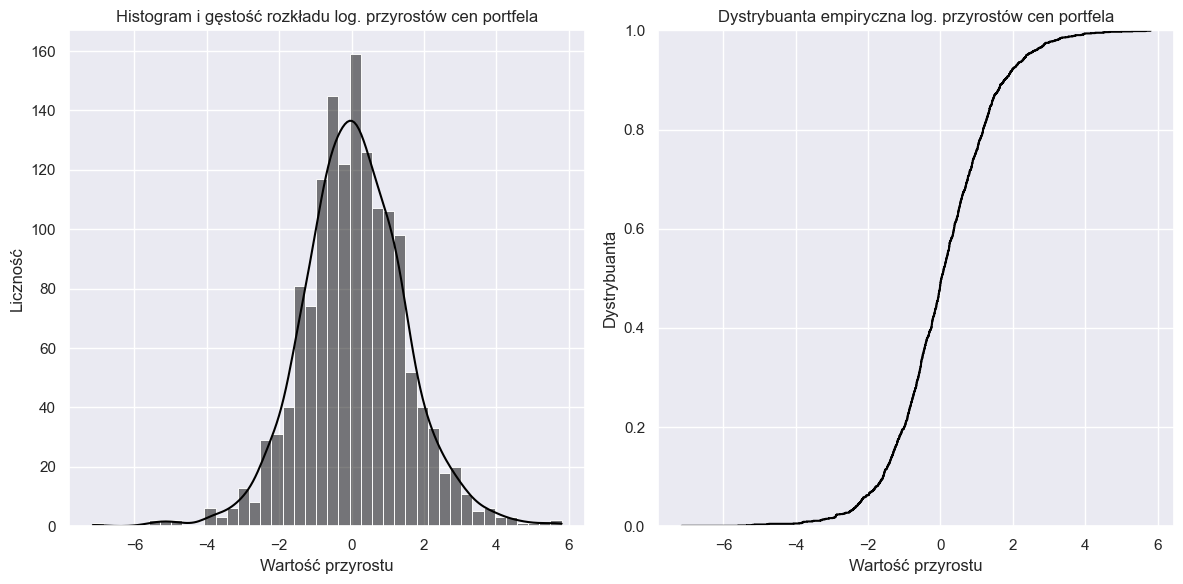

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram i gęstość rozkładu na pierwszym subplocie
sns.histplot(p, kde=True, ax=axes[0], color = 'black')
axes[0].set_title('Histogram i gęstość rozkładu log. przyrostów cen portfela')
axes[0].set_xlabel('Wartość przyrostu')
axes[0].set_ylabel('Liczność')

# Dystrybuanta empiryczna na drugim subplocie
sns.ecdfplot(p, ax=axes[1], color = 'black')
axes[1].set_title('Dystrybuanta empiryczna log. przyrostów cen portfela')
axes[1].set_xlabel('Wartość przyrostu')
axes[1].set_ylabel('Dystrybuanta')

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()


In [144]:
normality_tests(p)

0.9887533381275244 3.012130013863024e-09
Test Kolmogorova-Smirnova:
Statystyka: 0.0294, p-wartość: 0.1534
Wynik testu Kolmogorova-Smirnova:
Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu normalnego.

Test D'Agostino i Pearson:
Statystyka: 46.9615, p-wartość: 0.0000
Wynik testu D'Agostino i Pearson:
Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.

Test Shapiro-Wilka:
Statystyka: 0.9888, p-wartość: 0.0000
Wynik testu Shapiro-Wilka:
Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.


In [145]:
t_student_tests(p)
d_f, loc, sc = st.t.fit(p)
d_f = 7

7.402637599572305 0.06214820795242185 1.2191663148726324
Test t-Studenta:
Statystyka t: 0.1851, p-wartość: 0.8531
Wynik testu t-Studenta:
Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.

Test Kolmogorova-Smirnova:
Statystyka: 0.0145, p-wartość: 0.9117
Wynik testu Kolmogorova-Smirnova:
Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


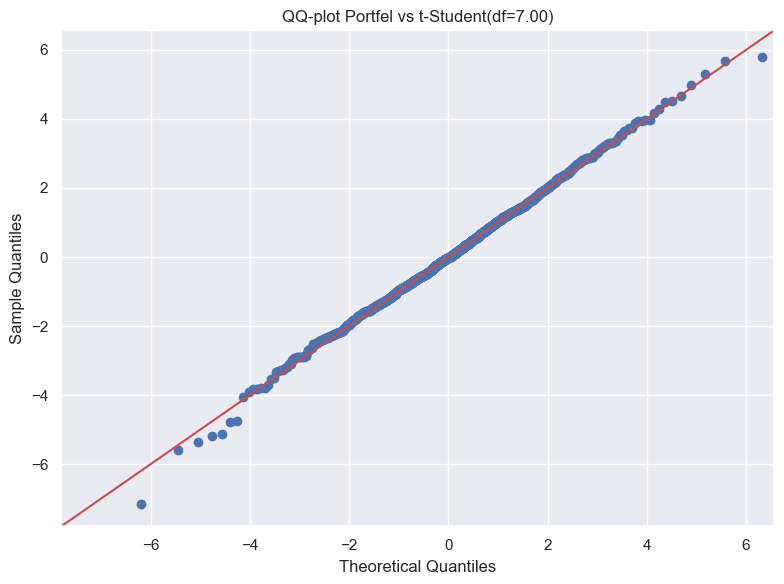

In [146]:
import statsmodels.api as sm

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sm.qqplot(p, color = 'black', dist=st.t(d_f, loc, sc), line='45', ax=ax)
plt.title(f'QQ-plot Portfel vs t-Student(df={d_f:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

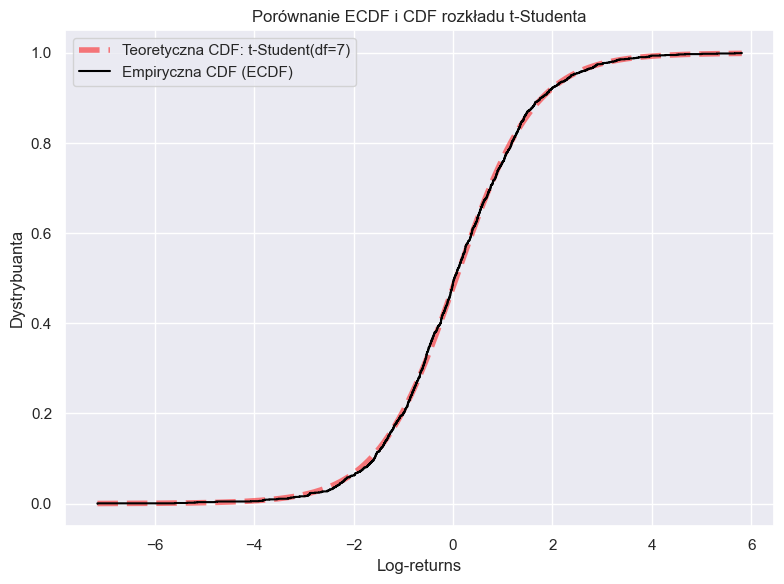

In [147]:
# Upewniamy się, że dane są 1D
p = np.ravel(p)

# Empiryczna dystrybuanta
ecdf = ECDF(p)

# Siatka do wykresu
x = np.linspace(min(p), max(p), 1000)
t_cdf = st.t.cdf(x, df=d_f, loc=loc, scale=sc)

# Wykres
plt.figure(figsize=(8, 6))
plt.plot(x, t_cdf, label=f'Teoretyczna CDF: t-Student(df={d_f})', color='red', linewidth=4, alpha=0.5, linestyle='dashed')
plt.step(ecdf.x, ecdf.y, label='Empiryczna CDF (ECDF)', where='post', color='black')
plt.title('Porównanie ECDF i CDF rozkładu t-Studenta')
plt.xlabel('Log-returns')
plt.ylabel('Dystrybuanta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
simulated_data = st.t.rvs(d_f, loc=loc, scale=sc, size=len(p))

parametry(portfel)

,Miara,Wartość
0,Odchylenie standardowe,1.4257
1,Odchylenie przeciętne,1.0903
2,Rozstęp międzykwartylowy,1.7619
3,Odchylenie ćwiartkowe,0.8809
4,Semiodchylenie standardowe,1.0506
5,Semiodchylenie przeciętne,0.5451
6,Średnia,0.0690
7,Współczynnik zmienności,20.6540


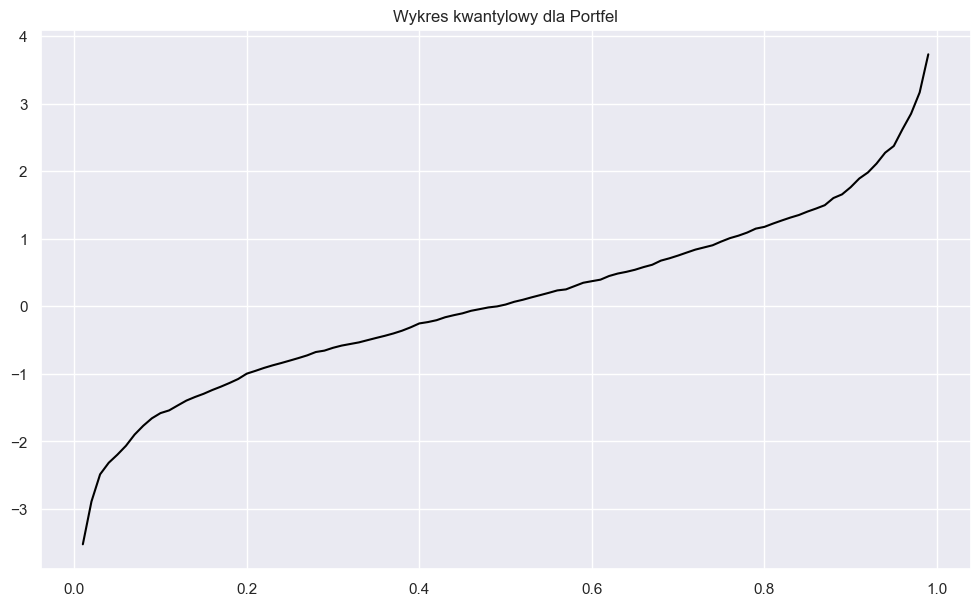

,Kwantyl,Wartość
0,0.0500,-2.1961
1,0.1500,-1.2947
2,0.2500,-0.8028
3,0.3500,-0.4680
4,0.4500,-0.1038
5,0.5500,0.1995
6,0.6500,0.5413
7,0.7500,0.9591
8,0.8500,1.4028
9,0.9500,2.3731


In [149]:
# kwantyle(simulated_data, 'Portfel')
kwantyle(p, 'Portfel')

In [150]:
# wartosc_dystrybuanty(simulated_data)
wartosc_dystrybuanty(p)

,Ustalona wartość,wartość dystrybuanty
0,0.0010,0.4905
1,0.0050,0.4919
2,0.0100,0.4953
3,0.0500,0.5068
4,0.1000,0.5231
5,0.5000,0.6364
6,1.0000,0.7585
7,2.0000,0.9227
8,3.0000,0.9756
9,4.0000,0.9939


### Dystrybuanty wielowymiarowe (empirycznie)

In [151]:
def empirical_cdf_2d(x_vals, y_vals, x_point, y_point):
    return np.mean((x_vals <= x_point) & (y_vals <= y_point))

# Przykład: dystrybuanta w punkcie (0.01, 0.005)
F_xy = empirical_cdf_2d(log_ret_tsmc, log_ret_smg, 0.01, 0.005)
print(f"F(0.01, 0.005) = {F_xy:.4f}")

F(0.01, 0.005) = 0.2680


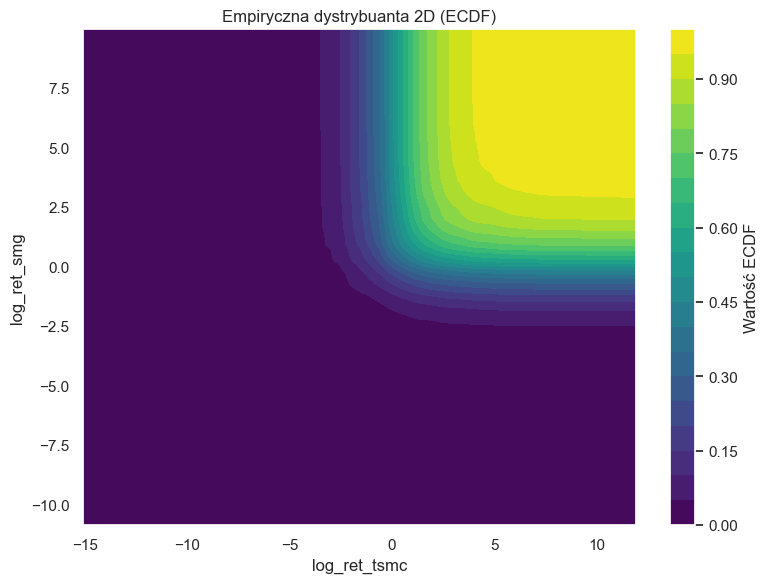

In [152]:

# Dane: wektory jednowymiarowe
x_vals = np.array(log_ret_tsmc)
y_vals = np.array(log_ret_smg)

# Tworzymy siatkę punktów
x_grid = np.linspace(np.min(x_vals), np.max(x_vals), 100)
y_grid = np.linspace(np.min(y_vals), np.max(y_vals), 100)
X, Y = np.meshgrid(x_grid, y_grid)

# Obliczamy ECDF w każdym punkcie siatki
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = np.mean((x_vals <= X[i, j]) & (y_vals <= Y[i, j]))

# Wykres: kontury lub heatmapa
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Wartość ECDF')
plt.title('Empiryczna dystrybuanta 2D (ECDF)')
plt.xlabel('log_ret_tsmc')
plt.ylabel('log_ret_smg')
plt.grid(True)
plt.tight_layout()
plt.show()

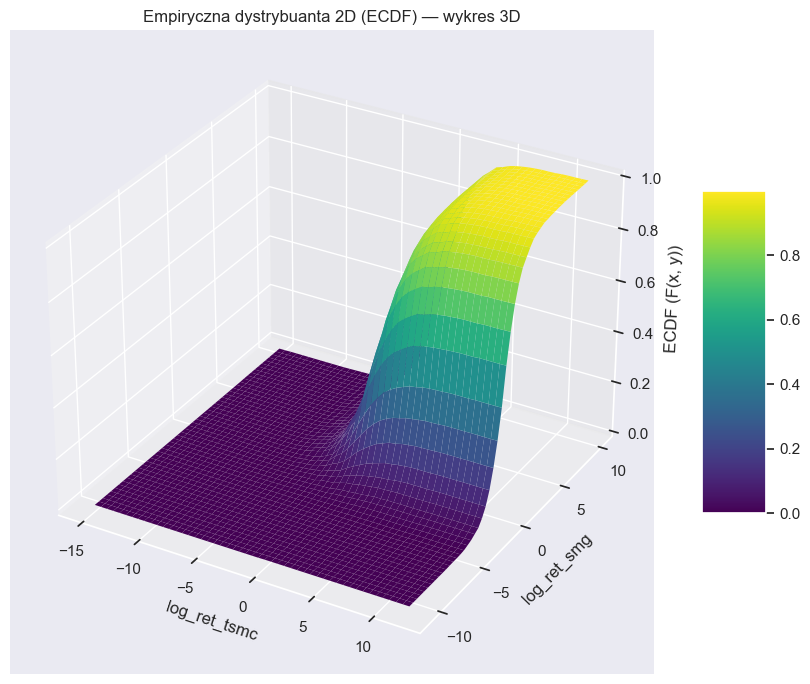

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dane
x_vals = np.array(log_ret_tsmc)
y_vals = np.array(log_ret_smg)

# Siatka
x_grid = np.linspace(np.min(x_vals), np.max(x_vals), 50)
y_grid = np.linspace(np.min(y_vals), np.max(y_vals), 50)
X, Y = np.meshgrid(x_grid, y_grid)

# Obliczanie ECDF na siatce
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = np.mean((x_vals <= X[i, j]) & (y_vals <= Y[i, j]))

# Rysowanie wykresu 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_xlabel('log_ret_tsmc')
ax.set_ylabel('log_ret_smg')
ax.set_zlabel('ECDF (F(x, y))')
ax.set_title('Empiryczna dystrybuanta 2D (ECDF) — wykres 3D')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

In [154]:
from scipy.stats import multivariate_t

# Dopasowany rozkład
rv = multivariate_t(loc=data_comb.mean(axis=0), shape=np.cov(data_comb.T), df=5)

# CDF w punkcie (x, y)
F_xy = rv.cdf([0.01, 0.005])
print(f"F(0.01, 0.005) = {F_xy:.4f}")

F(0.01, 0.005) = 0.2355


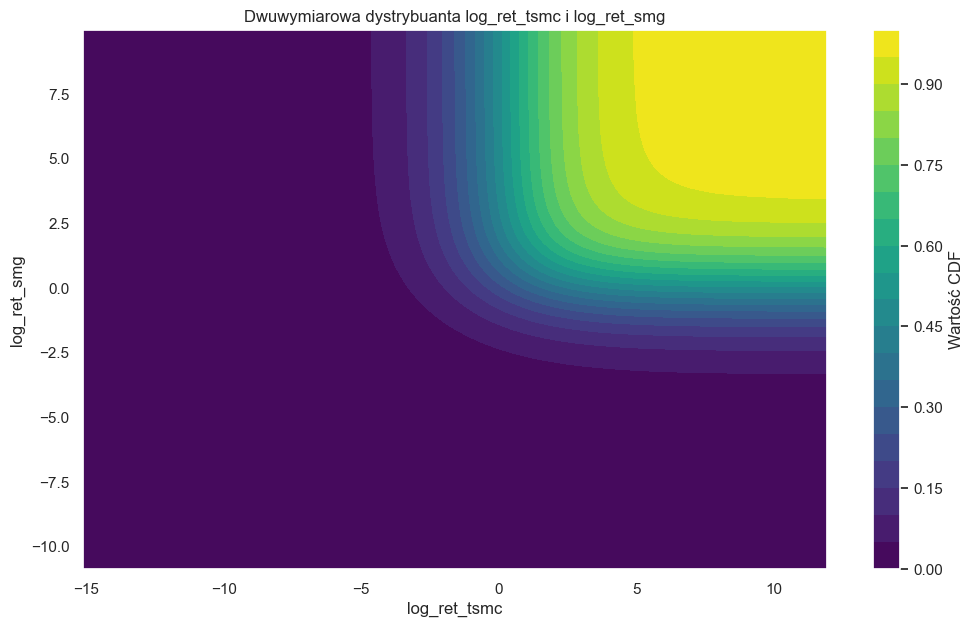

In [155]:
import matplotlib.pyplot as plt

# Siatka (jak wcześniej)
x = np.linspace(min(log_ret_tsmc), max(log_ret_tsmc), 100)
y = np.linspace(min(log_ret_smg), max(log_ret_smg), 100)
X, Y = np.meshgrid(x, y)

# Spłaszczone punkty do oceny
points = np.column_stack([X.ravel(), Y.ravel()])

# Oblicz CDF w każdym punkcie (uwaga: multivariate_t.cdf obsługuje tylko 1 punkt na raz!)
Z = np.array([rv.cdf(point) for point in points])

# Przywracamy do siatki 2D
Z = Z.reshape(X.shape)

# Kontur dystrybuanty
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Wartość CDF')
plt.title('Dwuwymiarowa dystrybuanta log_ret_tsmc i log_ret_smg')
plt.xlabel('log_ret_tsmc')
plt.ylabel('log_ret_smg')
plt.show()